<h1>Can a large scale dewatering project replace a pumping test?</h1>
<h2>A show case of the Tim groundwater familiy by an assessment of the Vlaketunnel dewatering in 2011.</h2>

The primary goal of this notebook is to illustrate the use of the Tim groundwater family. Usage of QGIS-Tim, TimML and data availale on the internet.

The notebook is presented during a workshop at the NHV Spring meeting at April 13 2023.

Prepared by Mark Bakker (TU Delft) and Hendrik Meuwese (Waterboard Scheldestromen).
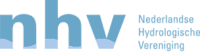

## Some Python imports

In [1]:
# import general packages
import numpy as np
import matplotlib.pyplot as plt
#from ipywidgets import Video
from io import StringIO
import timml as tml
import pandas as pd

# import specific functions for this notebook
import vlaketunnel_functions as vlake_func

# some plotting parameters
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 4) # set default figure size
plt.rcParams["contour.negative_linestyle"] = 'solid' # set default line style
plt.rcParams["figure.autolayout"] = True # same at tight_layout after every plot

# This is TimML in Python

A short example of TimML in Python interface.

The cell below is copied from the example notebooks (https://github.com/mbakker7/timml/blob/master/notebooks/timml_notebook0_sol.ipynb). It creates a groundwater model with a uniform flow and an extraction of 400 m3/day by a well.

Wanna now more about Tim? TKI TIM is active now: https://publicwiki.deltares.nl/display/TKIP/DEL156+TKI+TIM

Number of elements, Number of equations: 3 , 1
...
solution complete
.


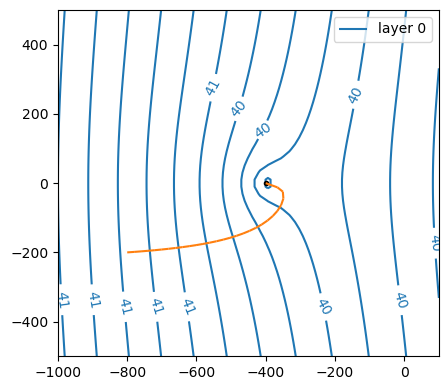

In [2]:
ml = tml.ModelMaq(kaq=10, z=[10, 0])
rf = tml.Constant(ml, xr=-1000, yr=0, hr=41)
uf = tml.Uflow(ml, slope=0.001, angle=0)
w = tml.Well(ml, xw=-400, yw=0, Qw=50., rw=0.2)
ml.solve()

ml.contour(win=[-1000, 100, -500, 500], ngr=50, levels=np.arange(39, 42, 0.1), ) #figsize=(6, 6))
ml.tracelines(-800 * np.ones(1), -200 * np.ones(1), np.zeros(1), hstepmax=20, color='C1')

The example is quite schematic. That is why TimML can be approaced via QGIS as well. We will used QGIS to create a TimML model later in this script.

The created model is exported to Python code, and imported to this notebook. Some pre-processing of model input and observations is done in the separate notebook.

First we give an overview of the case.

# Short overview of the case and model input


## Why was dewatering started?
The eastern part of the Vlaketunnel (A58 highway in province Zeeland) has lifted 10-15 cm at November 12 2010. The tunnel was closed immediately. The tunnel was stabilized by dumpertrucks and sand. 
A large scale dewatering started in November 26 2010.

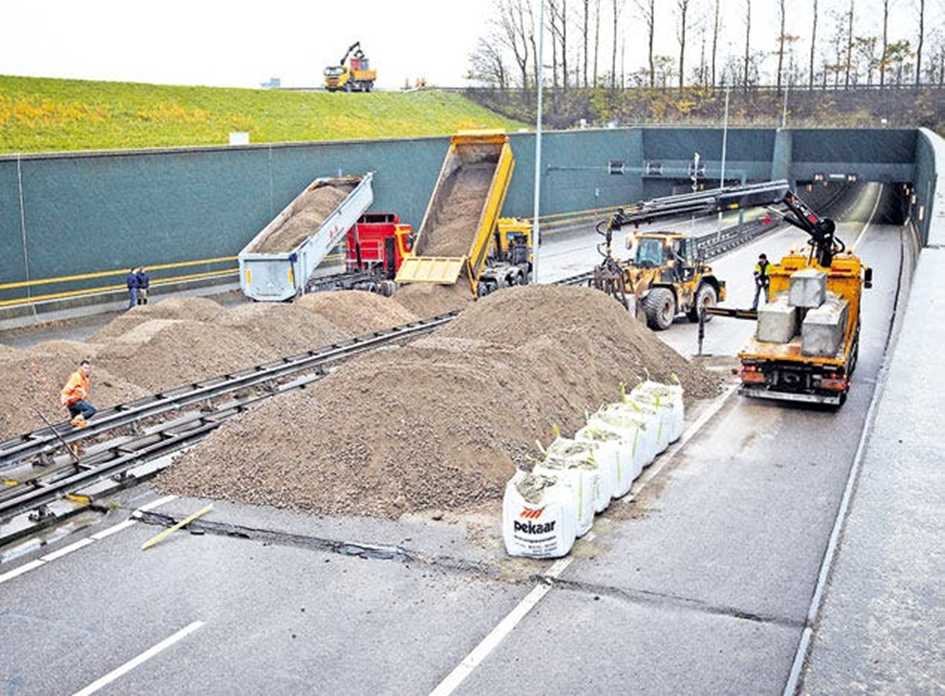

## Boundary conditions

### GeoTop
Most likely lithology according BRO GeoTop v1.5

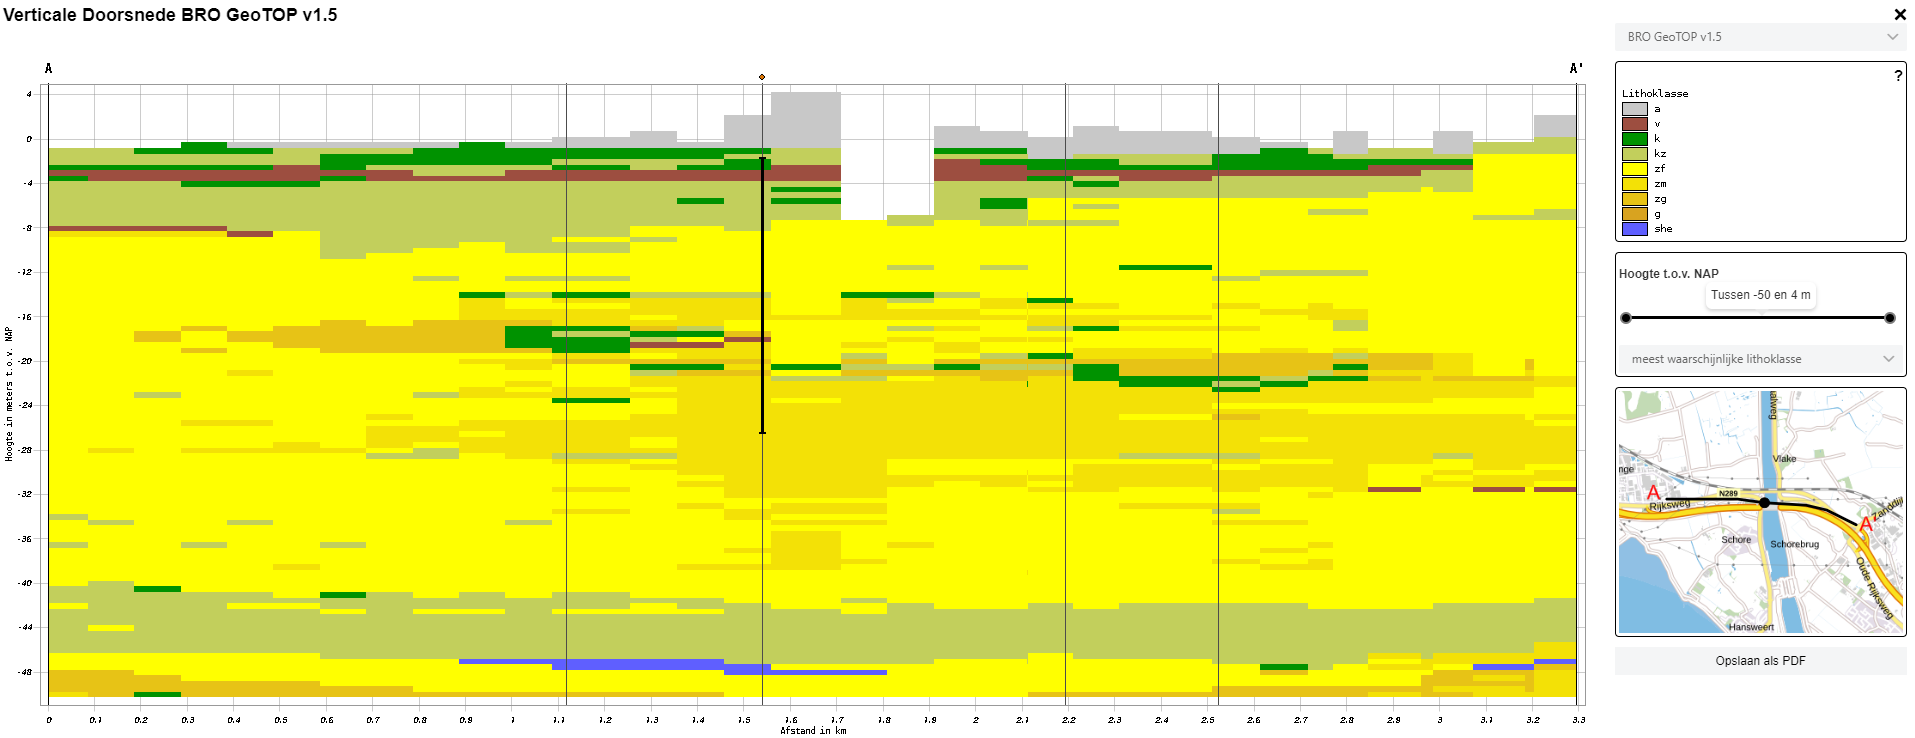

### Layer composition

| top (m NAP)  | bottom (m NAP)   |   hydrogeology | dewatering    |  channel  | kh  |
|--- |--- |--- |--- |--- | --- |
|   -1 |  -7  | confining toplayer   |    |   yes | c=1.000  |
|   -7 |  -15  | upper part aquifer   |   yes |   yes |  kh=5  |
|   -15 |  -30 | middle part aquifer   |    |    | kh=15  |
|   -30 |  -40 | lower part aquifer   |    |    | kh=5  |

### Discharge

Actual discharges are: east 325 m3/hour and the western part 75 m3/hour.

In [3]:
q_east_total = 325*24
q_east_nr_wells = 4
print(f'EAST discharge per well = {q_east_total/q_east_nr_wells} m3/day')

q_west_total = 75*24
q_west_nr_wells = 2
print(f'WEST discharge per well = {q_west_total/q_west_nr_wells} m3/day')

EAST discharge per well = 1950.0 m3/day
WEST discharge per well = 900.0 m3/day


## Observed drawdowns, relative to center of eastern dewatering site

Major dewatering is on eastern shore, see observed drawdown of 8 m at x=0.


Red color for observations west of Kanaal door Zuid-Beveland, maroon color for eastern shore. Mind the diffence of drawdown near x=1700 on both shores. 

In [4]:
# import on your laptop
# import pickle
# with open(r'data/df_dh.pkl', 'rb') as f:
#    df_dh = pickle.load(f)

# binder does not support pickle, we use text import
data_as_string = StringIO("""name;x;y;screen_top;tube_nr;dh_obs;ha;va;color;r
eastern_tunnel;59313.0;387345.0;-10.00;1.0;-8.000000;left;top;maroon;0.000000
pb6;58774.0;386980.0;-10.00;1.0;-2.000000;left;top;r;650.957756
B48F0233-001;58803.0;388144.0;-6.45;1.0;-0.549122;left;top;r;947.892926
B48F0233-002;58803.0;388144.0;-8.81;2.0;-0.307027;left;bottom;r;947.892926
B48F0233-003;58803.0;388144.0;-14.89;3.0;-0.338581;right;top;r;947.892926
B48F0203-002;59400.0;389050.0;-8.60;2.0;-0.821750;left;bottom;maroon;1707.218205
B48F0203-003;59400.0;389050.0;-14.40;3.0;-0.767000;right;top;maroon;1707.218205
B48F0232-002;58615.0;389021.0;-9.57;2.0;-0.029118;left;bottom;r;1815.538488
B48F0232-003;58615.0;389021.0;-14.61;3.0;-0.026286;right;top;r;1815.538488
B48F0231-002;57381.0;389003.0;-10.58;2.0;0.000676;left;bottom;r;2545.896306
B48F0231-003;57381.0;389003.0;-14.27;3.0;-0.016892;right;top;r;2545.896306""")
df_dh = pd.read_table(data_as_string, header=0, sep=";", index_col=0)

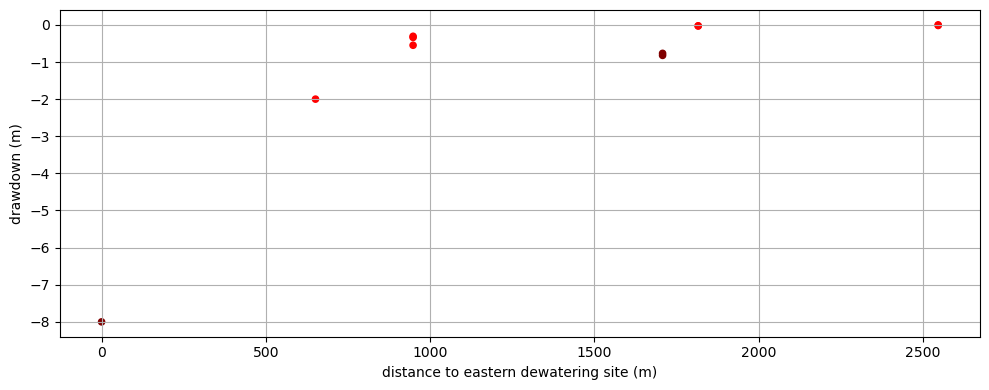

In [5]:
df_dh.plot.scatter(x='r', y='dh_obs', c='color', xlabel='distance to eastern dewatering site (m)', ylabel='drawdown (m)', figsize=(10,4), grid=True);

# Create TimML model using QGIS-Tim

QGIS-Tim is a graphical user interface in QGIS for TimML (steady-state) or TTim (transient) models (https://deltares.gitlab.io/imod/qgis-tim/index.html). QGIS-Tim can export a Python file with the model input. 

## Set up model
Because of the limited time during this workshop, the QGIS-Tim is prepared. The result is posted in the cell below.

In [6]:
#Video.from_file("data/screen_capture_qgis_tim_compressed.mp4", width=320, height=320)
#Video.from_file("data/screen_capture_qgis_tim_full.mp4", width=320, height=320)

## The model is now a function

The exported data from QGIS-Tim is in the file `data/export_qgis_tim.py`. The code is relative long, because each well is created seperatly. In the function `create_model` the code is included. The function will build the same model as created in QGIS-Tim. Some Python is added to make the code shorter. Decimals are removed, and lists are placed on one line. The model input can be changed via the input arguments of the function. When no arguments are given, the model uses the default parameters from QGIS-Tim. The only change is that for dewatering a superposition model is applied, therefore the top waterlevel is changed to 0.

Run the model, without the defaut plotting.

In [7]:
ml = vlake_func.create_model(do_plot=False)

Number of elements, Number of equations: 26 , 360
..........................
solution complete


What is the model input. The `vlake_func.plot_model_input` gives a schematic overview.

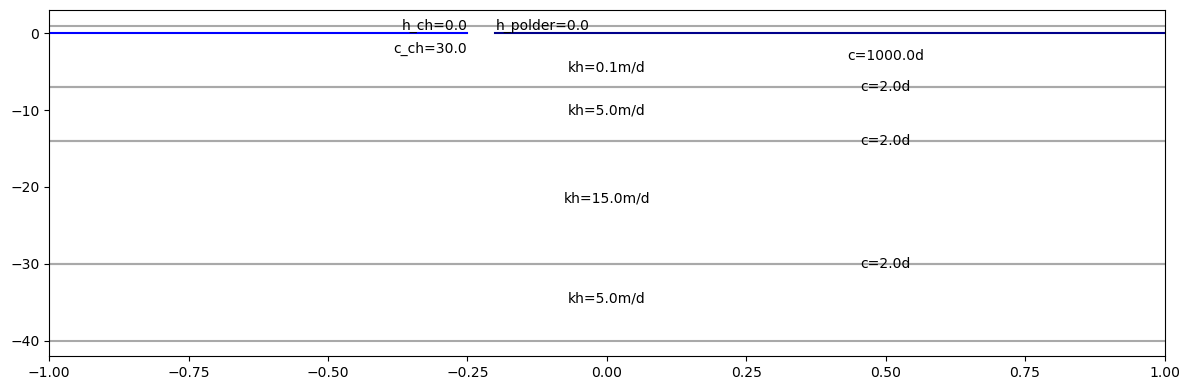

In [8]:
vlake_func.plot_model_input(ml)

Which drawdown is computed? And what are the observed drawdowns? The plot below will show.

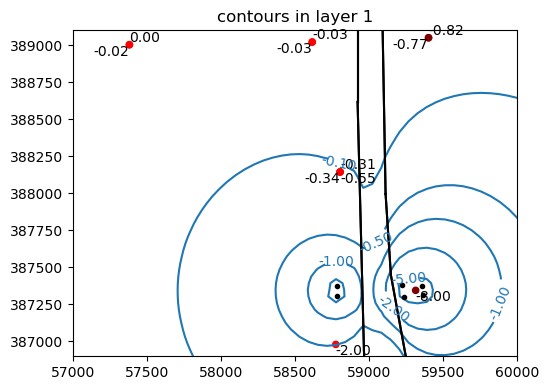

In [9]:
ml.contour(win=[57000, 60000, 386900, 389100], ngr=50, layers=1,
               levels=[-5,-2,-1,-0.5,-0.1], labels=True, decimals=2, legend=False, newfig=False);
plt.scatter(df_dh.x, df_dh.y, 20, c=df_dh.color)
for index, row in df_dh.iterrows():
    plt.annotate(f'{row.dh_obs:0.2f}', (row.x, row.y),ha=row.ha,va=row.va)
plt.title('contours in layer 1');

Both plots, and sections over the obervation locations are combined in one plotting function: `vlake_func.plot_model_results`.

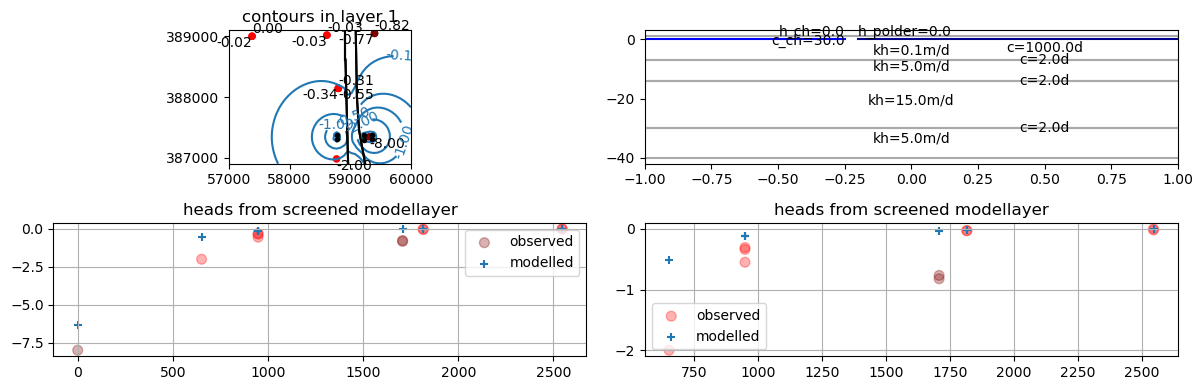

In [10]:
vlake_func.plot_model_results(ml, df_dh)

## Start history matching: calculated drawdown does not represent observed drawdown

The calculated drawdown is (by far) lower than the observed drawdown. The `vlake_func.create_model` function can be used to change input parameters. Th function calls the plot function by default.

### Lower permeabilty and higher bottom resistance of Kanaal door Zuid-Beveland

Number of elements, Number of equations: 26 , 360
..........................
solution complete


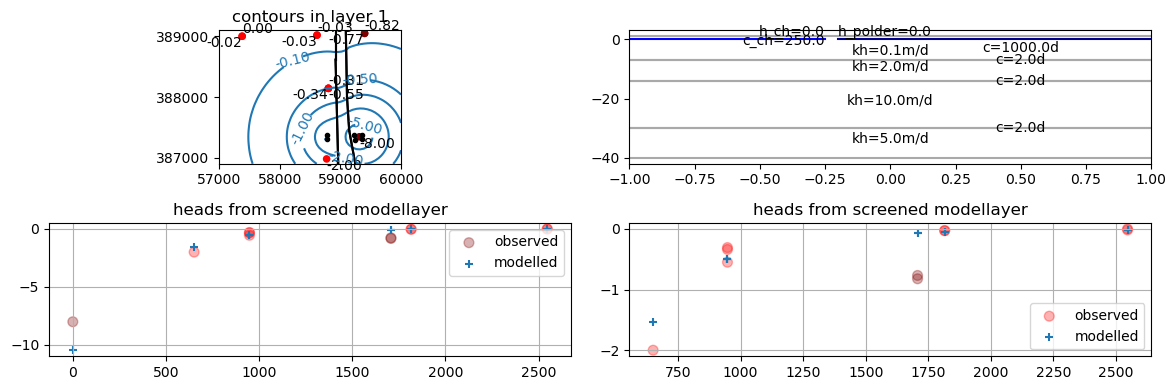

In [11]:
ml = vlake_func.create_model(kaq=[0.1, 2.0, 10.0, 5.0], c_channel_bot=250, df_dh=df_dh)

### ... and higher resistance to semi-confined top condtion

Number of elements, Number of equations: 26 , 360
..........................
solution complete


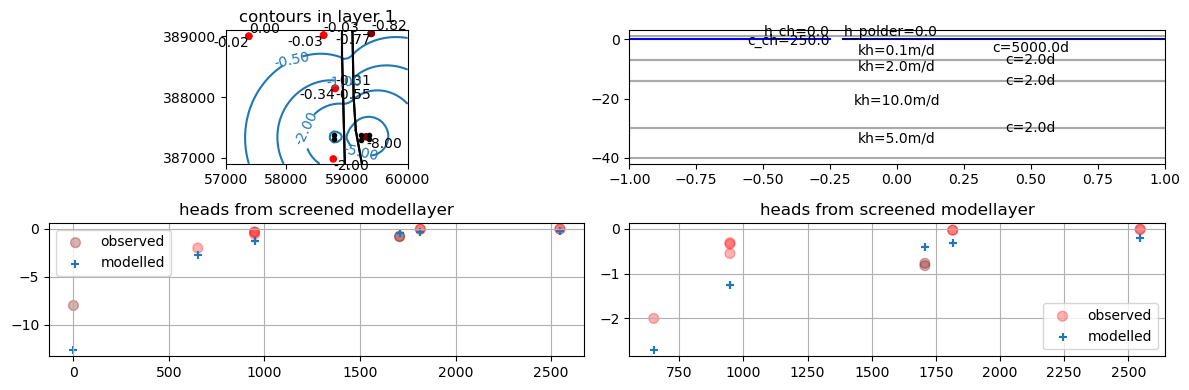

In [12]:
ml = vlake_func.create_model(kaq=[0.1, 2.0, 10.0, 5.0], c_channel_bot=250, c=[5000.0, 2.0, 2.0, 2.0], df_dh=df_dh)

# Up to you!

Which model input gives the best representation of the observation?

Is there one solution? Or is it likely that the area is not uniform?